# Sprawozdanie z Metod Inteligencji Obliczeniowej - lab 4
## Malgorzata Makiela
### 25.03.2024

## Zadanie 1.
Korzystając z materiałów przedstawionych na laboratorium utworzyłam sieć konwolucyjną Net, zdefiniowałam funkcję straty i optimizera a następnie wytrenowałam model w oparciu o zbiór FashionMNIST.

100%|██████████| 26421880/26421880 [00:02<00:00, 11061958.26it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197106.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3728342.73it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17232463.68it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

[1,  2000] loss: 1.493
[1,  4000] loss: 0.713
[1,  6000] loss: 0.616
[2,  2000] loss: 0.516
[2,  4000] loss: 0.497
[2,  6000] loss: 0.466
Trening ukończony


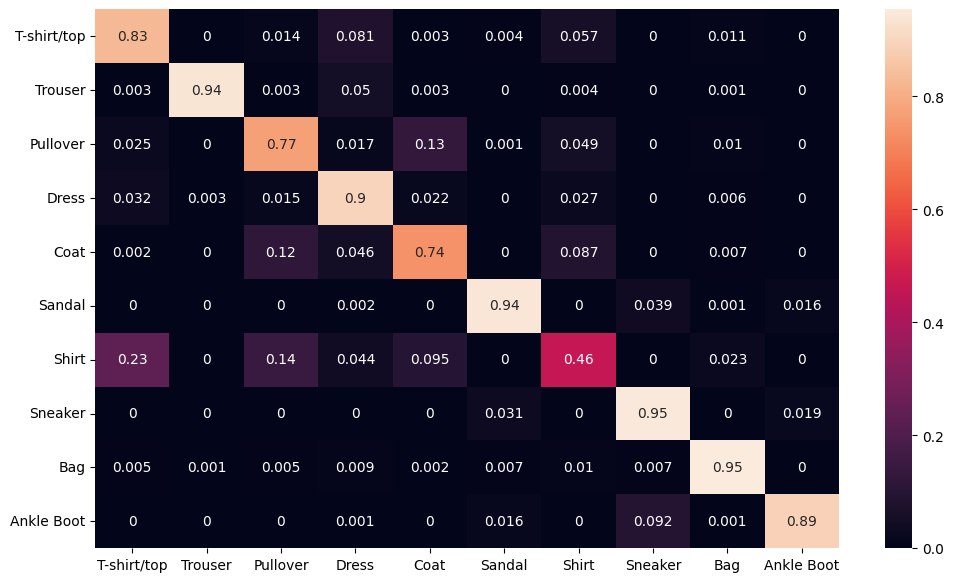

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


train_set = datasets.FashionMNIST(root='data', train=True, download = True, transform=ToTensor())
test_set = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

X_train = train_set.data
X_test = test_set.data
y_train = train_set.targets
y_test = test_set.targets


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # warstwa spłaszczająca
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)
for epoch in range(2):

    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):

        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

print('Trening ukończony')

y_pred = []
y_true = []

for inputs, labels in testloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()


Źródło, z którego korzystałam do wyrysowania macierzy pomyłek : https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

## Wnioski
Sieć dobrze sobie poradziła z podziałem ubrań na rodzaje. Najczęstsze pomyłki nastąpiły dla koszuli 'Shirt', która myliła się z t-shirt/top oraz z pullover. Jest to zrozumiałe zachowanie, ponieważ ubrania te są w kształcie bardzo do siebie podobne. Również zauważalna ilość elementów 'pullover' została zaklasyfikowana do 'coat' i vice versa, co również jest zrozumiałe. - kurtka i sweter mają bardzo podobne kształty. Dla pozostałych klas ubrań wyniki klasyfikacji były bardzo dokładne, z pojedynczymi pomyłkami, więc wnioskuję że sieć działa poprawnie i dobrze dobie poradziła z problemem.